In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
# predefined colors in figures
colors = ['#539fac', '#c84947','#f5b23e']
colorpair = ['#ce6552', '#6683e3']
kcolor = ['#fcba03', '#2e74c2', '#79b178', '#ca5d53', '#7d6285', '#a8a497']
klegd = {'Cluster 1':0, 'Cluster 2':1, 'Cluster 3':2, 'Cluster 4':3, 'Cluster 5':4, 'Cluster 6':5}
kcmap = {c:color for c, color in zip(klegd.values(), kcolor)}

### Import data

In [3]:
# load data
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
ctc = CellTypesCache(manifest_file = 'cell_types/manifest.json')

In [4]:
# download electrophysiology features of all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)
# download basic cell information from human neurons
cells = ctc.get_cells(species = [CellTypesApi.HUMAN])
cell_df = pd.DataFrame(cells)

cell_df = cell_df[['id','dendrite_type', 'structure_area_abbrev']].rename(columns={'id': 'specimen_id'})
all_df = pd.merge(left = cell_df.set_index('specimen_id'), right = ef_df, 
                  how = 'inner', left_on = 'specimen_id', right_on = 'specimen_id')

In [5]:
# exclude integer and binary features
all_df = all_df.drop(columns = ['id', 'thumbnail_sweep_id', 'rheobase_sweep_id', 'rheobase_sweep_number', 
                                'has_burst', 'has_delay', 'has_pause'])
# exclude features where over 30% of values are missing
all_df = all_df.drop(columns= ['slow_trough_t_long_square', 'slow_trough_t_ramp', 'slow_trough_t_short_square', 
                               'slow_trough_v_long_square', 'slow_trough_v_ramp', 'slow_trough_v_short_square'])
# exclude mechanical features that are irrelevant to the intrinsic characteristics of the neurons
all_df = all_df.drop(columns= ['electrode_0_pa', 'seal_gohm'])

# impute missing values
all_df['avg_isi'].fillna(1000, inplace=True) # 1000ms is the maximum value
all_df['adaptation'].fillna(1, inplace=True) 

# exclude cells containing null values in the electrophysiological features
nanlst = []
for cell in range(len(all_df)):
    if True in list(all_df.loc[cell].isnull()):
        nanlst.append(cell)
all_df = all_df.drop(nanlst)

In [6]:
d_type = {}
for n in all_df['dendrite_type']:
    if n not in d_type:
        d_type[n] = 0
    d_type[n] += 1
    
print('Types of dentrites: ')
print(d_type)

Types of dentrites: 
{'spiny': 321, 'aspiny': 78, 'sparsely spiny': 13}


In [7]:
# perform z-score transformation
df_copy = all_df.drop(columns = ['specimen_id', 'dendrite_type', 'structure_area_abbrev'])
all_value = df_copy.to_numpy()
all_value_sd = StandardScaler().fit_transform(all_value)

In [8]:
# create color map for figures
cmap = {typ:color for typ, color in zip(d_type.keys(), colors)}
colors_m = [cmap[typ] for typ in all_df['dendrite_type']]

### Principle component analysis

In [9]:
pca = PCA(n_components=10)
PC = pca.fit_transform(all_value_sd)
pc_r = pca.explained_variance_ratio_*100

print('PC1 {:5.2f}%\nPC2 {:5.2f}%\nPC3 {:5.2f}%'.format(pc_r[0], pc_r[1], pc_r[2]))
print('First three PCs explain {:5.2f}% variation in feature matrix.'.format(pc_r[:3].sum()))

PC1 30.90%
PC2 16.19%
PC3  9.14%
First three PCs explain 56.23% variation in feature matrix.


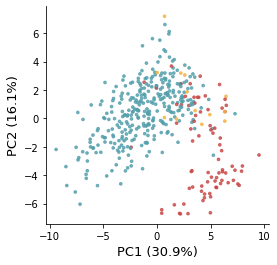

In [10]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(PC[:,0], PC[:,1], c=colors_m, s=7, alpha=0.8)
plt.xlabel('PC1 (' + str(pc_r[0])[:4] + '%)', fontsize=13)
plt.ylabel('PC2 (' + str(pc_r[1])[:4] + '%)', fontsize=13)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

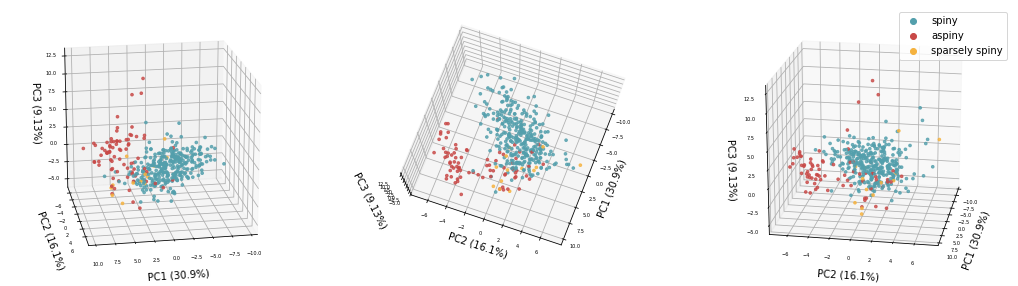

In [11]:
fig = plt.figure(figsize = (18, 5))
ax0 = fig.add_subplot(131, projection='3d')
ax0.scatter3D(PC[:,0], PC[:,1], PC[:,2], s=7, c=colors_m, alpha=0.8)
ax0.xaxis.set_tick_params(labelsize=5)
ax0.yaxis.set_tick_params(labelsize=5)
ax0.zaxis.set_tick_params(labelsize=5)
ax0.set_xlabel('PC1 (' + str(pc_r[0])[:4] + '%)')
ax0.set_ylabel('PC2 (' + str(pc_r[1])[:4] + '%)')
ax0.set_zlabel('PC3 (' + str(pc_r[2])[:4] + '%)')
ax0.view_init(20,80)

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter3D(PC[:,0], PC[:,1], PC[:,2], s=7, c=colors_m, alpha=0.8)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.zaxis.set_tick_params(labelsize=5)
ax1.set_xlabel('PC1 (' + str(pc_r[0])[:4] + '%)')
ax1.set_ylabel('PC2 (' + str(pc_r[1])[:4] + '%)')
ax1.set_zlabel('PC3 (' + str(pc_r[2])[:4] + '%)')
ax1.view_init(80,20)

ax2 = fig.add_subplot(133, projection='3d')
ax2.scatter3D(PC[:,0], PC[:,1], PC[:,2], s=7, c=colors_m, alpha=0.8)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in cmap.values()]
plt.legend(markers, cmap.keys(), numpoints=1)
ax2.xaxis.set_tick_params(labelsize=5)
ax2.yaxis.set_tick_params(labelsize=5)
ax2.zaxis.set_tick_params(labelsize=5)
ax2.set_xlabel('PC1 (' + str(pc_r[0])[:4] + '%)')
ax2.set_ylabel('PC2 (' + str(pc_r[1])[:4] + '%)')
ax2.set_zlabel('PC3 (' + str(pc_r[2])[:4] + '%)')
ax2.view_init(20,10)

plt.show()

### K-means clustering

In [12]:
n_trial = 10
n_cluster = 9

In [13]:
silhouette_km = np.empty((n_trial,n_cluster))
calinski_km = np.empty((n_trial,n_cluster))

for i in range(n_trial):
    for n in list(range(2, 2 + n_cluster)):
        kmeans = KMeans(n_clusters=n, n_init=len(all_value))
        kmeans.fit_transform(all_value_sd)
        silhouette_km[i, n-2] = metrics.silhouette_score(all_value_sd, kmeans.labels_)
        calinski_km[i, n-2] = metrics.calinski_harabasz_score(all_value_sd, kmeans.labels_)

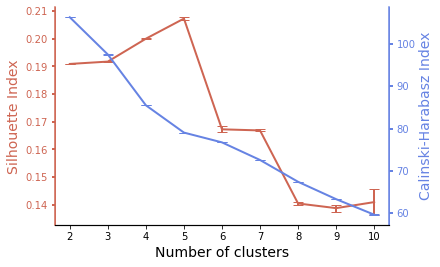

In [14]:
fig, ax1 = plt.subplots(figsize = (6, 4))

ax1.set_xlabel('Number of clusters', fontsize=14)
ax1.set_xticks(list(range(2, 11)))
ax1.set_ylabel('Silhouette Index', color=colorpair[0], fontsize=14)
ax1.errorbar(np.linspace(2, 10, 9), silhouette_km.mean(axis=0), yerr = silhouette_km.std(axis=0), 
             color=colorpair[0], linewidth=2, capsize=5)
ax1.tick_params(axis='y', color=colorpair[0], labelcolor=colorpair[0], width=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Calinski-Harabasz Index', color=colorpair[1], fontsize=14)
ax2.errorbar(np.linspace(2, 10, 9), calinski_km.mean(axis=0), yerr = calinski_km.std(axis=0), 
             color=colorpair[1], linewidth=2,capsize=5)
ax2.tick_params(axis='y', color=colorpair[1], labelcolor=colorpair[1], width=2)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.spines['left'].set_color(colorpair[0])
ax1.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color(colorpair[0])
ax1.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.2)

### t-distributed stochastic neighbor embedding

In [15]:
silhouette_km_t = np.empty((n_trial,n_cluster))
calinski_km_t = np.empty((n_trial,n_cluster))

for i in range(n_trial):
    for n in list(range(2, 2 + n_cluster)):
        tsne = manifold.TSNE(perplexity=20)
        Tsne = tsne.fit_transform(all_value_sd)
        kmeans = KMeans(n_clusters=n, n_init=len(all_value))
        kmeans.fit_transform(Tsne)
        silhouette_km_t[i, n-2] = metrics.silhouette_score(all_value_sd, kmeans.labels_)
        calinski_km_t[i, n-2] = metrics.calinski_harabasz_score(all_value_sd, kmeans.labels_)

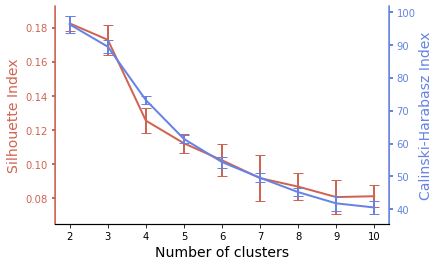

In [16]:
fig, ax1 = plt.subplots(figsize = (6, 4))

ax1.set_xlabel('Number of clusters', fontsize=14)
ax1.set_xticks(list(range(2, 11)))
ax1.set_ylabel('Silhouette Index', color=colorpair[0], fontsize=14)
ax1.errorbar(np.linspace(2, 10, 9), silhouette_km_t.mean(axis=0), yerr = silhouette_km_t.std(axis=0), 
             color=colorpair[0], linewidth=2, capsize=5)
ax1.tick_params(axis='y', color=colorpair[0], labelcolor=colorpair[0], width=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Calinski-Harabasz Index', color=colorpair[1], fontsize=14)
ax2.errorbar(np.linspace(2, 10, 9), calinski_km_t.mean(axis=0), yerr = calinski_km_t.std(axis=0), 
             color=colorpair[1], linewidth=2,capsize=5)
ax2.tick_params(axis='y', color=colorpair[1], labelcolor=colorpair[1], width=2)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.spines['left'].set_color(colorpair[0])
ax1.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color(colorpair[0])
ax1.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.2)

### Hierarchical Clustering

In [17]:
silhouette_hc = np.empty((n_trial,n_cluster))
calinski_hc = np.empty((n_trial,n_cluster))

for i in range(n_trial):
    for n in list(range(2, 2 + n_cluster)):
        hcluster = AgglomerativeClustering(n_clusters=n, distance_threshold=None).fit(all_value_sd)
        silhouette_hc[i, n-2] = metrics.silhouette_score(all_value_sd, hcluster.labels_)
        calinski_hc[i, n-2] = metrics.calinski_harabasz_score(all_value_sd, hcluster.labels_)

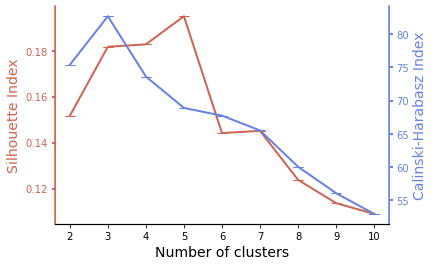

In [18]:
fig, ax1 = plt.subplots(figsize = (6, 4))

ax1.set_xlabel('Number of clusters', fontsize=14)
ax1.set_xticks(list(range(2, 11)))
ax1.set_ylabel('Silhouette Index', color=colorpair[0], fontsize=14)
ax1.errorbar(np.linspace(2, 10, 9), silhouette_hc.mean(axis=0), yerr = silhouette_hc.std(axis=0), 
             color=colorpair[0], linewidth=2, capsize=5)
ax1.tick_params(axis='y', color=colorpair[0], labelcolor=colorpair[0], width=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Calinski-Harabasz Index', color=colorpair[1], fontsize=14)
ax2.errorbar(np.linspace(2, 10, 9), calinski_hc.mean(axis=0), yerr = calinski_hc.std(axis=0), 
             color=colorpair[1], linewidth=2,capsize=5)
ax2.tick_params(axis='y', color=colorpair[1], labelcolor=colorpair[1], width=2)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.spines['left'].set_color(colorpair[0])
ax1.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color(colorpair[0])
ax1.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_color(colorpair[1])
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.2)

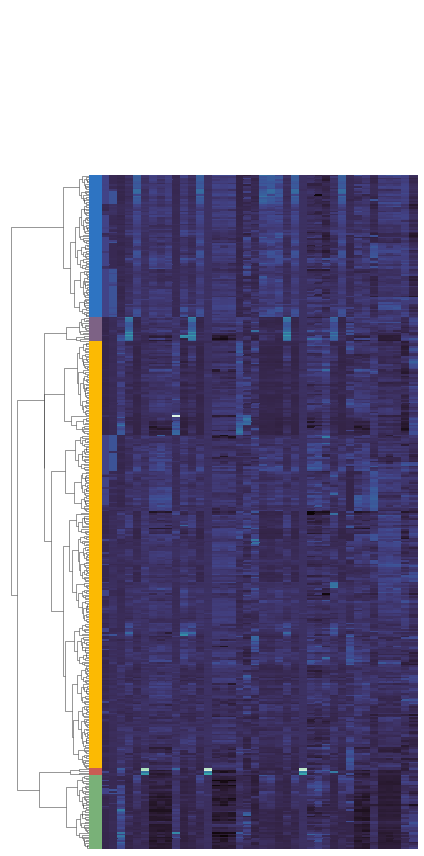

In [19]:
# plot dendrogram for hierarchical clustering result when cluster number is 5
hcluster = AgglomerativeClustering(n_clusters=5, distance_threshold=None).fit(all_value_sd)
colors_h = [kcmap[c] for c in hcluster.labels_]
maphcluster = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(all_value_sd)
counts = np.zeros(maphcluster.children_.shape[0])
linkage_matrix = np.column_stack([maphcluster.children_, maphcluster.distances_, counts]).astype(float)

sns.clustermap(all_value_sd, row_linkage=linkage_matrix, xticklabels=[], yticklabels=[], cmap='mako',
               col_cluster=False, row_colors=colors_h, method='ward', figsize=(6, 12), cbar_pos=None)

### Visualize clustering results on t-SNE axes

In [20]:
tsne = manifold.TSNE(perplexity=20)
Tsne = tsne.fit_transform(all_value_sd)

#k-means
kmeans5 = KMeans(n_clusters=5, n_init=len(all_value))
KM5=kmeans5.fit_transform(all_value_sd)
colors_k5 = [kcmap[c] for c in kmeans5.labels_]

#k-means on t-SNE
kmeans2 = KMeans(n_clusters=2, n_init=len(all_value))
KM2=kmeans2.fit_transform(Tsne)
colors_k2 = [kcmap[c] for c in kmeans2.labels_]

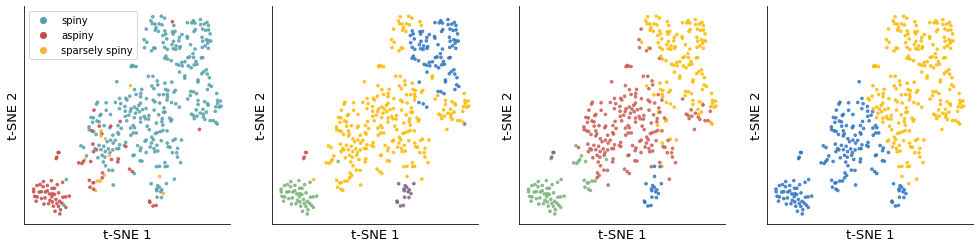

In [23]:
fig = plt.figure(figsize = (17, 4))

ax = fig.add_subplot(1, 4, 1)
plt.scatter(Tsne[:,0], Tsne[:,1], c=colors_m, s=7, alpha=0.8)
plt.legend(markers, cmap.keys(), numpoints=1, prop={'size':10})
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE 1', fontsize=13)
plt.ylabel('t-SNE 2', fontsize=13)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# hierarchical clustering, n=5
ax = fig.add_subplot(1, 4, 2)
plt.scatter(Tsne[:,0], Tsne[:,1], c=colors_h, s=7, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE 1', fontsize=13)
plt.ylabel('t-SNE 2', fontsize=13)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# K-means, n=5
ax = fig.add_subplot(1, 4, 3)
plt.scatter(Tsne[:,0], Tsne[:,1], c=colors_k5, s=7, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE 1', fontsize=13)
plt.ylabel('t-SNE 2', fontsize=13)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# K-means on t-SNE, n=2
ax = fig.add_subplot(1, 4, 4)
plt.scatter(Tsne[:,0], Tsne[:,1], c=colors_k2, s=7, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE 1', fontsize=13)
plt.ylabel('t-SNE 2', fontsize=13)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')